In [3]:
import numpy as np
import scipy as sp
from scipy.integrate import odeint
import math
from numpy import linalg
import sympy

from sympy import symbols
from sympy import *
from sympy.physics.mechanics import dynamicsymbols, init_vprinting

import plotly.graph_objects as go
import plotly.express as px

In [4]:
class mugas_rigid_body_functions:
  
  def __init__(self): 
    self=[];

  def simulateDySystem(self, dynamicSystemModel, Tmax, dT, X0, sysPara, figTitle, xLabel, yLabel):
    t = np.linspace(0, Tmax, int(Tmax/dT+1))
    sol = odeint(dynamicSystemModel, X0, t, args=(sysPara,));
    self.soln=sol;
    fig = go.Figure()
    [nt,nS]=sol.shape;

    # Add traces
    for nn in range(nS):
      fig.add_trace(go.Scatter(x=t, y=sol[:,nn], mode='lines+markers', name='x'+str(nn+1)))
      fig.update_layout(title=figTitle, xaxis=dict(title=xLabel),yaxis=dict(title=yLabel))
    
    fig.show()
    return [t,sol,fig] 

  def hatMatrix(self, X):
    return np.array([[0., -X[2], X[1]],[X[2], 0., -X[0]],[-X[1], X[0], 0.]])

  def qFromAxisAngles(self, theta, unitAxis):
    return np.concatenate(([np.cos(theta/2)],np.sin(theta/2)*np.array(unitAxis)))

  def RfromQuaternions(self,q):
    q0=q[0]; w=q[1:];
    R=np.identity(3)+2*q0*self.hatMatrix(w)+2*self.hatMatrix(w) @ self.hatMatrix(w);
    return R

  def rotationMatrix2EulerAngles(self,R):
    if R[2,2] <1:
      if R[2,2] > -1:
        theta2=math.acos(R[2,2]);
        theta1=math.atan2(R[0,2],R[1,2]);
        theta3=math.atan2(R[2,0],-R[2,1]);
      else: #R[2,2]=-1 No Unique solution 
        theta2=np.pi;
        theta1=-math.atan2(R[0,1],-R[0,0]);
        theta3=0;
    else: # R[2,2] = +1 No Unique solution
      theta2 = 0;
      theta1 = math.atan2(R[0,1],R[0,0]) ;
      theta3 = 0;
    return [np.pi-theta1,theta2,np.pi-theta3]

  def Re3equalsgamma(self,gamma):
    theta=math.acos(gamma[2]);
    n1=-gamma[1]/np.sin(theta);
    n2=gamma[0]/np.sin(theta);
    q00=self.qFromAxisAngles(theta,[n1,n2,0]);

    return self.RfromQuaternions(q00)

  def rotate_and_translate(self,objectVertices,R,o):
    #object vertices should be given as an numpy array of shape (3,n) 
    #Ex - X=[0, 0, 2, 2, 0, 0, 2, 2], Y=[0, 2, 2, 0, 0, 2, 2, 0], Z=[0, 0, 0, 0, 1, 1, 1, 1]; objectVertices=[X,Y,Z]
    return np.array([[o[0],o[1],o[2]]]).T + R @ objectVertices



  def addOrthNormFrame(self, fig, o, R, axisRange, axisColor):
    e1=[1,0,0]; e2=[0,1,0]; e3=[0,0,1];
    b1=R @ e1; b2=R @ e2; b3=R @ e3;
    fig.add_trace(go.Scatter3d(x=[str(o[0]),str(o[0]+b1[0])], y=[str(o[1]),str(o[1]+b1[1])], z=[str(o[2]),str(o[2]+b1[2])], hoverinfo='x+y+z', mode='lines', line=dict(width=8, color=axisColor)))
    fig.add_trace(go.Scatter3d(x=[str(o[0]),str(o[0]+b2[0])], y=[str(o[1]),str(o[1]+b2[1])], z=[str(o[2]),str(o[2]+b2[2])], hoverinfo='x+y+z', mode='lines', line=dict(width=8, color=axisColor)))
    fig.add_trace(go.Scatter3d(x=[str(o[0]),str(o[0]+b3[0])], y=[str(o[1]),str(o[1]+b3[1])], z=[str(o[2]),str(o[2]+b3[2])], hoverinfo='x+y+z', mode='lines', line=dict(width=8, color=axisColor)))
    fig.update_layout(showlegend=False, scene=dict(xaxis=dict(range=axisRange[0], autorange=False), yaxis=dict(range=axisRange[1], autorange=False), zaxis=dict(range=axisRange[2], autorange=False), aspectratio=dict(x=1, y=1, z=1)))
    return fig

  def cube_vertices(self,cubeDimensions):
    l=cubeDimensions['l']; w=cubeDimensions['w']; h=cubeDimensions['h'];
    xp=cubeDimensions['xp']; yp=cubeDimensions['yp']; zp=cubeDimensions['zp'];
    #X=[0, 0, l, l, 0, 0, l, l]; Y=[0, w, w, 0, 0, w, w, 0]; Z=[0, 0, 0, 0, h, h, h, h]; XX=[X,Y,Z];
    # X=[-xp, -xp, l-xp, l-xp, -xp, -xp, l-xp, l-xp]; Y=[-yp, w-yp, w-yp, -yp, -yp, w-yp, w-yp, -yp]; Z=[-zp, -zp, -zp, -zp, h-zp, h-zp, h-zp, h-zp]; XX=[X,Y,Z];
    X=[-l/2, -l/2, l/2, l/2, -l/2, -l/2, l/2, l/2]; Y=[-w/2, w/2, w/2, -w/2, -w/2, w/2, w/2, -w/2]; Z=[-h/2, -h/2, -h/2, -h/2, h/2, h/2, h/2, h/2]; XX=[X,Y,Z]; 
    return XX


  def animate_particle_motion(self, XX, axisRange, figTitle):
    xx=[jj[0] for jj in XX]
    yy=[jj[1] for jj in XX]
    zz=[jj[2] for jj in XX]

    fig = go.Figure(
        data=[go.Scatter3d(x=[xx[0]], y=[yy[0]],z=[zz[0]],
                        mode="markers",
                        marker=dict(color="red", size=10)),
              go.Scatter3d(x=xx, y=yy,z=zz, name='Path',
                        mode="lines",
                        line=dict(color="blue", width=2))],
        layout=go.Layout(
            scene = dict(
                        xaxis=dict(range=axisRange[0], autorange=False),
                        yaxis=dict(range=axisRange[1], autorange=False),
                        zaxis=dict(range=axisRange[2], autorange=False),
                        aspectratio=dict(x=1, y=1, z=1),
            ),
            title_text=figTitle, hovermode="closest",
            updatemenus=[dict(type="buttons",
                              buttons=[dict(label="Play",
                                            method="animate",
                                            args=[None])])]),
        frames=[go.Frame(
            data=[go.Scatter3d(
                x=[p[0]],
                y=[p[1]],
                z=[p[2]],
                name='Particle',
                mode="markers",
                marker=dict(color="red", size=10))])

            for p in XX]
    )

    fig.show()
    return fig

  def animated_cube_flat_shading(self, cubeVertices,figTitle):
    fig = go.Figure(
        frames=[go.Frame(data=[
          go.Mesh3d(
            # 8 vertices of a cube
            x=xx[0][0],
            y=xx[0][1],
            z=xx[0][2],
            # i, j and k give the vertices of triangles
            i = [7, 0, 0, 0, 4, 4, 6, 6, 4, 0, 3, 2],
            j = [3, 4, 1, 2, 5, 6, 5, 2, 0, 1, 6, 3],
            k = [0, 7, 2, 3, 6, 7, 1, 1, 5, 5, 7, 6],
            name='y',
            opacity=0.6,
            color='#DC143C',
            flatshading = True)]) for xx in cubeVertices])

    fig.add_trace(go.Mesh3d(
            # 8 vertices of a cube
            x=cubeVertices[0][0][0],
            y=cubeVertices[0][0][1],
            z=cubeVertices[0][0][2],
            # i, j and k give the vertices of triangles
            i = [7, 0, 0, 0, 4, 4, 6, 6, 4, 0, 3, 2],
            j = [3, 4, 1, 2, 5, 6, 5, 2, 0, 1, 6, 3],
            k = [0, 7, 2, 3, 6, 7, 1, 1, 5, 5, 7, 6],
            name='y',
            opacity=0.6,
            color='#DC143C',
            flatshading = True)
        )
    
    duration=10;
    fig.update_layout(
          title=figTitle,
          width=600,
          height=600,
          scene=dict(
                      xaxis=dict(range=[-5., 5.], autorange=False),
                      yaxis=dict(range=[-5., 5.], autorange=False),
                      zaxis=dict(range=[-5., 5.], autorange=False),
                      aspectratio=dict(x=1, y=1, z=1),
                      ),
          updatemenus=[dict(type="buttons",
                              buttons=[dict(label="Play",
                                            method="animate",
                                            args=[None, {"frame": {"duration": duration},"mode": "immediate","fromcurrent": True, "transition": {"duration": duration, "easing": "linear"},}]
                                            )])])
    len(fig.frames)
    fig.show()
    return fig
  
  def simulating_a_cube(self, dt, Tmax, cubeDimensions, parameters,ICs):
    XX=self.cube_vertices(cubeDimensions);
    
    #Xs=self.eulers_method(dt,Tmax,parameters,ICs);
    Xs=self.runga_kutta_method(dt,Tmax,parameters,ICs);
    ICR=ICs[0][0];
    XX0=ICR @ XX;
    
    rotatedVertices=[[XX0]]
    for X in Xs:
      #print(X[0])
      R=X[0][0]; 
      o=X[0][1];
      XXi=self.rotate_and_translate(XX,R,o);
      XX0=XXi;
      rotatedVertices+=[[XX0]];
    return rotatedVertices


  def eulers_method(self, dt,Tmax,parameters,ICs):
    M=parameters['M']; II=parameters['II'];
    invII=linalg.inv(II) ;
    timeSteps=np.arange(0,Tmax+dt,dt);
    R=ICs[0][0]; o=ICs[0][1];
    omega=ICs[1]; doto=ICs[2]; Xc=ICs[3];
    X=ICs;
    spi=R@II@R.T@omega; p=M*doto;
    Xout=[X];
    for t in timeSteps:
      [taue,fe]=externalForceModel(self, parameters,X);
      [taua,fa]=actuator(self, parameters, t, X,taue,fe);
      
      dspi=taue+taua;
      dp=fe+fa;
      #dXc=controller_dynamics(self, t,X,taue,fe,parameters)
      
      if linalg.norm(omega)>=0.0001:
        nomega=omega/linalg.norm(omega);
        thetaomegat=dt*linalg.norm(omega);
      else:
        nomega=np.array([0,0,0]);
        thetaomegat=0;
      qomegat=np.concatenate(([np.cos(thetaomegat/2)],np.sin(thetaomegat/2)*nomega));
      R=self.RfromQuaternions(qomegat) @ R;
      o=o+dt*doto;
      spi=spi+dt*dspi;
      p=p+dt*dp;
      doto=p/M;
      omega=R @ invII @ R.T @ spi;
      Xc=Xc#+dt*dXc;
      X=[[R,o],omega,doto, Xc];
      Xout+=[X]
        
    return Xout

  def runga_kutta_method(self, dt,Tmax,parameters,ICs):
    M=parameters['M']; II=parameters['II']; 
    invII=linalg.inv(II) ;
    timeSteps=np.arange(0,Tmax+dt,dt);
    X=ICs;
    Xout=[X];
    for t in timeSteps:
      Y1=self.rk4_function(0.5*dt, X, t, X, parameters);
      Y2=self.rk4_function(0.5*dt, X, t+0.5*dt, Y1, parameters);
      Y3=self.rk4_function(dt, X, t+0.5*dt, Y2, parameters);

      [thetaomega1,nomega1,doto1,dp1,dspi1,dXc1]=self.rigid_body_system(parameters, t, X);
      [thetaomega2,nomega2,doto2,dp2,dspi2,dXc2]=self.rigid_body_system(parameters, t+0.5*dt, Y1);
      [thetaomega3,nomega3,doto3,dp3,dspi3,dXc3]=self.rigid_body_system(parameters, t+0.5*dt, Y2);
      [thetaomega4,nomega4,doto4,dp4,dspi4,dXc4]=self.rigid_body_system(parameters, t+dt, Y3);
      
      omegak=(dt/6.0)*(thetaomega1*nomega1+2*thetaomega2*nomega2+2*thetaomega3*nomega3+thetaomega4*nomega4)
      if linalg.norm(omegak)>=0.0001:
        nomegak=omegak/linalg.norm(omegak);
        thetaomegak=linalg.norm(omegak);
      else:
        nomegak=np.array([0,0,0]);
        thetaomegak=0;
      qomegak=np.concatenate(([np.cos(thetaomegak/2)],np.sin(thetaomegak/2)*nomegak));
      Rk=self.RfromQuaternions(qomegak) @ X[0][0];
      
      dotok=(1./6.0)*(doto1+2*doto2+2*doto3+doto4);
      dpk=(1./6.0)*(dp1+2*dp2+2*dp3+dp4);
      dspik=(1./6.0)*(dspi1+2*dspi2+2*dspi3+dspi4);
      dXck=(1./6.0)*(dXc1+2*dXc2+2*dXc3+dXc4);
      
      ok=X[0][1]+dt*dotok;
      pk=X[2]+dt*dpk;
      spik=X[0][0]@II@X[0][0].T@X[1]+dt*dspik;
      Xck=X[3]+dt*dXck;
      omegak=Rk @ linalg.inv(II) @ Rk.T @ spik;
      X=[[Rk,ok],omegak,pk,Xck];
      Xout+=[X]   
    return Xout

  def rk4_function(self, dtk, X, tk, Xk, parameters):
    M=parameters['M']; II=parameters['II']; 
    [thetaomega1,nomega1,doto1,dp1,dspi1,dXc1]=self.rigid_body_system(parameters, tk, Xk)
    qomega1=np.concatenate(([np.cos(dtk*thetaomega1/2)],np.sin(dtk*thetaomega1/2)*nomega1));
    R1=self.RfromQuaternions(qomega1)@X[0][0];
    p1=X[2]+dtk*dp1;
    spi1=X[0][0]@II@X[0][0].T@X[1]+dtk*dspi1; omega1=R1@linalg.inv(parameters['II'])@R1.T@spi1;
    X1=[[R1, X[0][1]+dtk*doto1],omega1,p1, X[3]+dtk*dXc1]
    return X1

  def rigid_body_system(self, parameters, t, X):
    barX=parameters['CM']; M=parameters['M'];
    R=X[0][0]; omega=X[1]; p=X[2]; 
    
    [taue,fe]=externalForceModel(self, parameters,X);
    [taua,fa]=actuator(self, parameters, t, X,taue,fe);
    
    doto=p/M; 
    dp=fe+fa;
    dspi=taue+taua;
    dXc=np.array([0.,0.,0.]); #External Dynamics #controller_dynamics(self, t,X,taue,fe,parameters)
    if linalg.norm(omega)>=0.0001:
      nomega=omega/linalg.norm(omega);
      thetaomega=linalg.norm(omega);
    else:
      nomega=np.array([0,0,0]);
      thetaomega=0;
    return [thetaomega,nomega,doto,dp,dspi,dXc]

In [5]:
def LinearSystemModel(X, t, A):
  dXdt=A @ X;
  return dXdt

In [6]:
def externalForceModel(qq,parameters,X):
  #Heavy Top Object
  M=parameters['M']; II=parameters['II']; g=parameters['g']; CM=parameters['CM'];
  R=X[0][0]; omega=X[1]; spi=R@ II@ R.T @ omega
  # taue=(-M*g*qq.hatMatrix(R@CM) @ [0,0,1])-0*spi;
  fe=np.array([0.,0.,0.]);
  return [np.array([0.,0.,0.]),fe]

def actuator(qq,parameters, t, X, taue,fe):
  tauu=np.array([0,0,0]);
  fu=np.array([0,0,0]);
  return [tauu,fu]
def externalForceModel(qq,parameters,X):
  #Heavy Top Object
  M=parameters['M']; II=parameters['II']; g=parameters['g']; CM=parameters['CM'];
  R=X[0][0]; omega=X[1]; spi=R@ II@ R.T @ omega
  # taue=(-M*g*qq.hatMatrix(R@CM) @ [0,0,1])-0*spi;
  fe=np.array([0.,0.,0.]);
  return [np.array([0.,0.,0.]),fe]

def actuator(qq,parameters, t, X, taue,fe):
  tauu=np.array([0,0,0]);
  fu=np.array([0,0,0]);
  return [tauu,fu]

In [7]:
mr=mugas_rigid_body_functions()

## Moment of Inertia of long Pressure cooker base

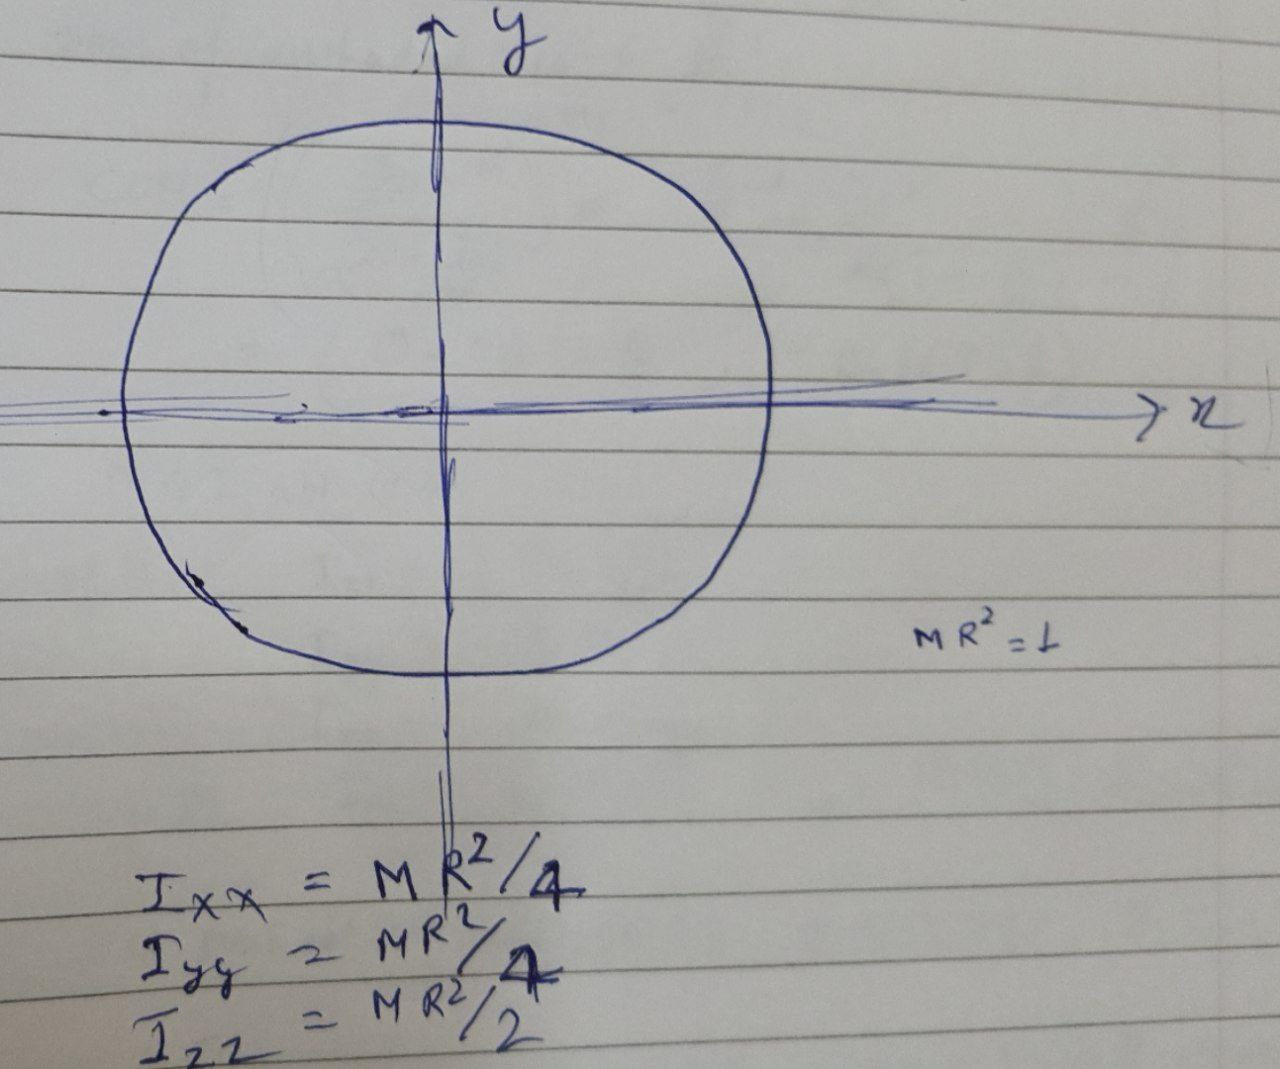


Dimensions are 2r,2r,0.1r and the cuboidal shape is used which covers the coooker base and centre of mass is also located in that manner

## angular velocity about axis1

In [10]:
cubeDimensions={'l':2,'w':2.,'h':0.1,'xp':0.,'yp':0.,'zp':0.,};
parameters={'CM':np.array([cubeDimensions['l']/2-cubeDimensions['xp'],cubeDimensions['w']/2-cubeDimensions['yp'],cubeDimensions['h']/2-cubeDimensions['zp']]), 'g':1, 'M':1, 'II':np.array([[0.25,0.,0.],[0.,0.25,0.],[0.,0.,0.5]])};
ICq=mr.qFromAxisAngles(0,np.array([1,0,0])); ICR=mr.RfromQuaternions(ICq);
IComega=np.array([1.,0.01,0.]); ICo=np.array([0.,0.,0.]); ICp=np.array([0.,0.,0.]);
ICXC=np.array([0,0,0]);
ICs=[[ICR,ICo],IComega,ICp,ICXC]

In [11]:
aa4=mr.simulating_a_cube(0.05, 30., cubeDimensions, parameters,ICs)
fig1=mr.animated_cube_flat_shading(aa4,'Cooker base rotating about axis1')

As visible in above simulation; the motion is stable because it is not an intermediate axis

In [12]:
II=parameters['II']; 
magPi=linalg.norm(II@IComega);
KE=0.5*IComega.T@II@IComega;
spatialpi=ICR@II@IComega;

In [13]:
dphi, dtheta = np.pi / 25.0, np.pi / 25.0
[phi, theta] = np.mgrid[0:np.pi + dphi * 1.5:dphi, 0:2 * np.pi +
                        dtheta * 1.5:dtheta]
# m0 = 4; m1 = 3; m2 = 2; m3 = 3; m4 = 6; m5 = 2; m6 = 6; m7 = 4;
r=magPi;  a=np.sqrt(2*KE*II[0,0]); b=np.sqrt(2*KE*II[1,1]); c=np.sqrt(2*KE*II[2,2]);# a=2.38047614284762; b=2.58198889747161; c=1.29099444873581; # 
# Applying the parametric equation..
#r = (np.sin(m0 * phi) ** m1 + np.cos(m2 * phi) ** m3 + np.sin(m4 * theta) ** m5 + np.cos(m6 * theta) ** m7)
x1 = r * np.sin(phi) * np.cos(theta); z1 = r * np.cos(phi); y1 = r * np.sin(phi) * np.sin(theta)
x2 = a * np.sin(phi) * np.cos(theta); z2 = c * np.cos(phi); y2 = b * np.sin(phi) * np.sin(theta)


surface1 = go.Surface(x=x1, y=y1, z=z1, colorscale='Inferno')
surface2 = go.Surface(x=x2, y=y2, z=z2, colorscale='deep')
# data = [surface1,surface2]
data = [surface1,surface2]
layout = go.Layout(
    title='Intersection of the angular momentum sphere and the Kinetic Energy Ellipsoid',
    scene=dict(
        xaxis=dict(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        ),
        yaxis=dict(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        ),
        zaxis=dict(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        )
    )
)
fig = go.Figure(data=data, layout=layout)
fig.show()

In the above graph, the intersection set is continuous and pretty much large; giving many states to rotate

## angular velocity about  axis2

In [14]:
IComega1=np.array([0.,1.,0.01])
ICs1=[[ICR,ICo],IComega1,ICp,ICXC]

In [16]:
aa4=mr.simulating_a_cube(0.05, 30., cubeDimensions, parameters,ICs1)
fig1=mr.animated_cube_flat_shading(aa4,'cooker base about axis2')

The above motion is also stable 

In [17]:
II=parameters['II']; 
magPi1=linalg.norm(II@IComega1);
KE1=0.5*IComega1.T@II@IComega1;
spatialpi1=ICR@II@IComega1;

In [18]:
dphi, dtheta = np.pi / 25.0, np.pi / 25.0
[phi, theta] = np.mgrid[0:np.pi + dphi * 1.5:dphi, 0:2 * np.pi +
                        dtheta * 1.5:dtheta]
# m0 = 4; m1 = 3; m2 = 2; m3 = 3; m4 = 6; m5 = 2; m6 = 6; m7 = 4;
r=magPi1;  a=np.sqrt(2*KE1*II[0,0]); b=np.sqrt(2*KE1*II[1,1]); c=np.sqrt(2*KE1*II[2,2]);# a=2.38047614284762; b=2.58198889747161; c=1.29099444873581; # 
# Applying the parametric equation..
#r = (np.sin(m0 * phi) ** m1 + np.cos(m2 * phi) ** m3 + np.sin(m4 * theta) ** m5 + np.cos(m6 * theta) ** m7)
x1 = r * np.sin(phi) * np.cos(theta); z1 = r * np.cos(phi); y1 = r * np.sin(phi) * np.sin(theta)
x2 = a * np.sin(phi) * np.cos(theta); z2 = c * np.cos(phi); y2 = b * np.sin(phi) * np.sin(theta)


surface1 = go.Surface(x=x1, y=y1, z=z1, colorscale='Inferno')
surface2 = go.Surface(x=x2, y=y2, z=z2, colorscale='deep')
# data = [surface1,surface2]
data = [surface1, surface2]
layout = go.Layout(
    title='Intersection of the angular momentum sphere and the Kinetic Energy Ellipsoid',
    scene=dict(
        xaxis=dict(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        ),
        yaxis=dict(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        ),
        zaxis=dict(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        )
    )
)
fig = go.Figure(data=data, layout=layout)
fig.show()

The intersection set is small 

In [20]:
IComega2=np.array([0.,0.01,1.])
ICs2=[[ICR,ICo],IComega2,ICp,ICXC]

In [21]:
aa4=mr.simulating_a_cube(0.05, 30., cubeDimensions, parameters,ICs2)
fig1=mr.animated_cube_flat_shading(aa4,'cooker base rotating about max MOI axis')

In [22]:
II=parameters['II']; 
magPi=linalg.norm(II@IComega2);
KE=0.5*IComega2.T@II@IComega2;
spatialpi=ICR@II@IComega2;

In [23]:
dphi, dtheta = np.pi / 25.0, np.pi / 25.0
[phi, theta] = np.mgrid[0:np.pi + dphi * 1.5:dphi, 0:2 * np.pi +
                        dtheta * 1.5:dtheta]
# m0 = 4; m1 = 3; m2 = 2; m3 = 3; m4 = 6; m5 = 2; m6 = 6; m7 = 4;
r=magPi;  a=np.sqrt(2*KE*II[0,0]); b=np.sqrt(2*KE*II[1,1]); c=np.sqrt(2*KE*II[2,2]);# a=2.38047614284762; b=2.58198889747161; c=1.29099444873581; # 
# Applying the parametric equation..
#r = (np.sin(m0 * phi) ** m1 + np.cos(m2 * phi) ** m3 + np.sin(m4 * theta) ** m5 + np.cos(m6 * theta) ** m7)
x1 = r * np.sin(phi) * np.cos(theta); z1 = r * np.cos(phi); y1 = r * np.sin(phi) * np.sin(theta)
x2 = a * np.sin(phi) * np.cos(theta); z2 = c * np.cos(phi); y2 = b * np.sin(phi) * np.sin(theta)


surface1 = go.Surface(x=x1, y=y1, z=z1, colorscale='Inferno')
surface2 = go.Surface(x=x2, y=y2, z=z2, colorscale='deep')
# data = [surface1,surface2]
data = [surface1,surface2]
layout = go.Layout(
    title='Intersection of the angular momentum sphere and the Kinetic Energy Ellipsoid',
    scene=dict(
        xaxis=dict(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        ),
        yaxis=dict(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        ),
        zaxis=dict(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        )
    )
)
fig = go.Figure(data=data, layout=layout)
fig.show()

Again, the intersection set is pretty much small (only at z axis poles of sphere) 

Hence if MOI about 2 axis is same then there will be no unstable motion